# Projeto

Este projeto desenvolverá um modelo transformer BERT e o treinará utilizando a tarefa de Masked Language Model (MLM), aplicado ao contexto das músicas brasileiras de forró.

Para isso, foi utilizado o dataset de: [inserir link do dataset]

# Teoria

### Transformer

- Encoder: O Encoder recebe a sequência de entrada (por exemplo, uma frase em português) e a processa para criar uma representação vetorial de alta qualidade dessa sequência. Essa representação captura o significado e o contexto de cada palavra em relação às outras palavras da frase.
- Decoder: O Decoder recebe a representação gerada pelo Encoder e a utiliza para gerar uma sequência de saída (por exemplo, a tradução da frase para o inglês).

### Modelo BERT

Bidirectional Encoder Representations from Transformers

1. Bloco transformer com componentes/operacoes Multi-Head Self-Attention, Feed Foward Network e dropout.

2. Customização do modelo, definindo como calcular as metricas que serao utilizadas, neste caso calculando a perda com Sparse Categorical Crossentropy e atualizando com a média da perda.

3. Construção do modelo BERT para o mlm.

4. Callback para a geração de texto para tokens mascarados e apresentação de resultados.

### Masked Language Model

Um Masked Language Model (MLM) é um tipo de modelo de linguagem amplamente utilizado em processamento de linguagem natural.

Durante o treinamento, uma parte dos tokens (palavras ou subpalavras) no texto de entrada é substituída por um token especial de máscara, como "[MASK]". O objetivo do modelo é prever corretamente quais eram os tokens originais que foram mascarados.

Essa estratégia obriga o modelo a aprender contextos ricos e relações entre as palavras, o que é fundamental para o desempenho em diversas tarefas, como análise de sentimentos, tradução, e resposta a perguntas. Modelos famosos que utilizam essa técnica incluem o BERT, que demonstrou ganhos significativos em várias benchmarks de NLP .



## Configuração para o projeto

Importanto as bibliotecas necesssárias para o desenvolvimento do projeto.

In [123]:
import os

os.environ[ "KERAS_BACKEND" ] = "torch"  # or jax, or tensorflow

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

In [124]:
# Identificar se está usando a CPU ou GPU no PyTorch

import torch

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( f"Using device: {device}" )

Using device: cuda


In [125]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 16  #32
    LR = 0.0001  #0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

# Carregando os dados

Primeiro, vamos carregar os dados que estão na pasta "musicas".

Duas funções serão utilizadas para isso:

- Uma irá criar uma lista contendo o conteúdo dos arquivos.
- A outra ficará responsável por criar um dataframe.

In [126]:
def get_text_list_from_files( files ) -> list[ str ]:
    """
       Esta função irá retornar uma lista contendo todas as frases dos arquivos.
    """
    text_list: list[ str ] = [ ]
    for name in files:
        with open( name, "r", encoding = "utf-8" ) as f:
            # Lê o conteúdo completo do arquivo; se houver várias linhas e desejar cada linha
            # como exemplo separado, use um loop for sobre f.
            text_list.append( f.read() )
    return text_list


def get_data_from_text_files( folder_name: str ):
    """
    Retorna um dataframe contendo todas as letras dos arquivos.

    :param folder_name: Nome da pasta.
    :type folder_name: str
    :return:
    """

    # Arquivos de texto que serão utilizados
    files = glob.glob( f"musicas/{folder_name}/*.txt" )

    # Listas com os textos
    texts: list[ str ] = get_text_list_from_files( files )

    # Criação de um dataframe, com coluna chamada "lyric"
    df = pd.DataFrame( { "lyric": texts } )

    # Sample -> pega uma amostra aleatória
    # len(df) -> do tamanho do df original
    # reset_index -> ao usar sample, o índice original das linhas é mantido
    df = df.sample( len( df ) ).reset_index( drop = True )
    return df


train_df = get_data_from_text_files( "train" )
test_df = get_data_from_text_files( "test" )

print( f"Tamanho do DataFrame de Treino: {len( train_df )}" )
print( f"Tamanho do DataFrame de Teste/Validação: {len( test_df )}" )

Tamanho do DataFrame de Treino: 1444
Tamanho do DataFrame de Teste/Validação: 361


In [127]:
train_df.head()

,lyric
0,Tá ruim fingir que tá tudo bem Tentei colocar ...
1,Olha que é papo de pegada não é papo de dinhei...
2,Liga liga liga Eu disse que eu nunca mais pro...
3,Alavantu pra tu anarriê pra eu Tu no teu canto...
4,No forró do A Nós vamos amar No forró do B Nós...


# Padronização dos textos

In [128]:

def custom_standardization( input_data ):
    """Normalização de texto. """
    # Verifica o tipo para decodificar se for bytes (comum vindo de algumas fontes)
    if isinstance( input_data, bytes ):
        input_data = input_data.decode( "utf-8" )
    # Converte para minúsculas (Python string method)
    lowercase = input_data.lower()
    # Remove tag <br /> usando re.sub
    stripped_html = re.sub( "<br />", " ", lowercase )
    # Remove pontuação e caracteres especiais usando re.sub
    # Nota: O padrão [%s] funciona com tf.strings, mas com re.sub é mais comum usar um conjunto [] diretamente.
    # Escape os caracteres especiais se necessário dentro do conjunto.
    # Ajuste a string de caracteres a remover conforme sua necessidade.
    no_special_chars = re.sub( r"[!\"#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]", "", stripped_html )
    return no_special_chars

In [129]:
print( "Padronizando textos de treino..." )
train_texts_raw = train_df.lyric.values.tolist()

# Aplica a função a cada item da lista
train_texts_standardized = [ custom_standardization( text ) for text in train_texts_raw ]

print( "Padronização concluída." )

Padronizando textos de treino...
Padronização concluída.


## Vetorização de Texto

Para um transformer, a vetorização de um texto é o processo fundamental de transformar o texto bruto em uma representação numérica que o modelo possa entender e processar. Em essência, é como traduzir a linguagem humana para a linguagem matemática que o transformer consegue trabalhar.

Imagine que o transformer é um computador que só entende números. Para que ele consiga ler e compreender um texto, precisamos converter cada palavra (ou parte da palavra) em um conjunto de números. Esse conjunto de números é o que chamamos de vetor.

Aqui está um detalhamento do processo de vetorização para um transformer:

1. Tokenização: O primeiro passo é dividir o texto em unidades menores, chamadas tokens. Um token pode ser uma palavra inteira, parte de uma palavra (subpalavra), ou até mesmo um caractere. Por exemplo, a frase "O gato comeu o rato" poderia ser tokenizada como: ["O", "gato", "comeu", "o", "rato"].

2. Criação do Vocabulário: Em seguida, é criado um vocabulário, que é uma lista de todos os tokens únicos presentes no conjunto de dados de treinamento do modelo. Cada token nesse vocabulário recebe um índice único.

3. Indexação: Cada token no texto de entrada é então mapeado para o seu índice correspondente no vocabulário. Usando o exemplo anterior e supondo um vocabulário, os tokens poderiam ser convertidos em índices como: [10, 25, 50, 10, 75].

4. Embedding: A etapa crucial para transformers é a criação de embeddings. Em vez de simplesmente usar os índices brutos, cada índice é transformado em um vetor denso de números reais. Esse vetor captura o significado semântico e as relações entre as palavras.

    - Word Embeddings: Cada palavra (ou token) é associada a um vetor de baixa dimensionalidade (por exemplo, 512 ou 768 dimensões). Palavras com significados semelhantes tendem a ter vetores próximos no espaço vetorial. Por exemplo, os vetores para "gato" e "felino" provavelmente estarão mais próximos do que os vetores para "gato" e "carro".

    - Positional Embeddings: Transformers também precisam entender a ordem das palavras em uma frase. Para isso, são adicionados embeddings posicionais aos word embeddings. Esses vetores codificam a posição de cada token na sequência, permitindo que o modelo diferencie entre "o gato comeu o rato" e "o rato comeu o gato".

5. Input para o Transformer: Os vetores resultantes (a soma dos word embeddings e positional embeddings para cada token) são então alimentados como entrada para as diferentes camadas do transformer (como as camadas de atenção).

In [130]:
def get_vectorize_layer( texts: list[ str ], vocab_size: int, max_seq: int, special_tokens: list = [ "[MASK]" ] ):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence length.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """

    # Criação da camada de TextVectorization
    vectorize_layer = TextVectorization(
            max_tokens = vocab_size,  # Define o tamanho máximo do vocabulário
            output_mode = "int",  # Define que a saída deve ser uma sequência de números inteiros
            standardize = None,  # Aplicar função de pré-processamento
            output_sequence_length = max_seq,  # Garantir que toda sequência de saída tenha comprimento max_seq
    )

    # todo Mostrar um exemplo

    # Adaptação aos textos de entrada
    # A camada "sabe" como mapear palavras para números inteiros, com base nas entradas
    vectorize_layer.adapt( texts )

    # Obtem o vocabulário aprendido pelo adapt (inclui '' e '[UNK]')
    vocab_adaptado = vectorize_layer.get_vocabulary()

    # Calcula quantos tokens 'reais' (não '', não '[UNK]', não especiais) podemos manter
    num_special_tokens = len( special_tokens )
    # Precisamos de espaço para: '' (1), '[UNK]' (1), N palavras frequentes, M tokens especiais
    # Tamanho total <= vocab_size
    num_palavras_frequentes = vocab_size - 2 - num_special_tokens

    # Garante que não tentemos pegar mais palavras do que as aprendidas, ou um número negativo
    num_palavras_frequentes = max( 0, min( num_palavras_frequentes, len( vocab_adaptado ) - 2 ) )

    # Pega as N palavras mais frequentes (começando do índice 2 do vocab adaptado)
    palavras_frequentes = vocab_adaptado[ 2: 2 + num_palavras_frequentes ]

    # --- CONSTRUÇÃO EXPLÍCITA DO VOCABULÁRIO FINAL ---
    # Começa com os tokens padrão de padding e OOV
    vocabulario_final = [ "", "[UNK]" ]
    # Adiciona as palavras mais frequentes
    vocabulario_final.extend( palavras_frequentes )
    # Adiciona os tokens especiais no final
    vocabulario_final.extend( special_tokens )

    # Define o vocabulário usando a lista final CORRETAMENTE ESTRUTURADA
    print( f"Definindo vocabulário final explícito com ~{len( vocabulario_final )} tokens..." )
    vectorize_layer.set_vocabulary( vocabulario_final )

    # Verificação opcional do tamanho final e índices importantes
    vocab_real_final = vectorize_layer.get_vocabulary()
    print( f"Tamanho real do vocabulário após set_vocabulary: {len( vocab_real_final )}" )
    try:
        print( f"Índice de '': {vocab_real_final.index( '' )}" )  # Deve ser 0
        print( f"Índice de '[UNK]': {vocab_real_final.index( '[UNK]' )}" )  # Deve ser 1
        for token in special_tokens:
            print( f"Índice de '{token}': {vocab_real_final.index( token )}" )  # Deve estar no final
    except ValueError as e:
        print( f"Erro ao verificar índices: {e}" )  # Indica problema na construção

    # Retorna a camada
    return vectorize_layer

In [131]:
# Pegando a camada de vetorização
vectorize_layer = get_vectorize_layer(
        train_texts_standardized,
        config.VOCAB_SIZE,
        config.MAX_LEN,
        special_tokens = [ "[mask]" ],
)

# Processamento de um novo dado: "[mask]"
# - Aplica a função de pré-processamento
# - Divide em token, pega seu id e cria uma sequência de comprimento config.MAX_LEN
# - Converte o resultado para um array NumPy
# - Pega o id do "[mask]"
mask_token_id = vectorize_layer( [ "[mask]" ] )[ 0 ][ 0 ].item()

Definindo vocabulário final explícito com ~11168 tokens...
Tamanho real do vocabulário após set_vocabulary: 11168
Índice de '': 0
Índice de '[UNK]': 1
Índice de '[mask]': 11167


In [132]:
def encode( texts ):
    """ Retorna um array NumPy das sequências numéricas dos textos de entrada."""
    # Criação das sequências numéricas para os textos de entrada
    # vectorize_layer retorna tensor PyTorch (no backend torch)
    encoded_texts = vectorize_layer( texts )
    # Retorna o tensor diretamente (pode estar na GPU)
    return encoded_texts

### Mascaramento de Texto

Em essência, o mascaramento envolve ocultar aleatoriamente algumas das palavras (ou tokens) em uma sequência de texto de entrada. O objetivo é fazer com que o modelo aprenda a prever as palavras que foram mascaradas, com base no contexto das palavras vizinhas não mascaradas.

Imagine a frase: "O gato está dormindo no tapete."

No processo de mascaramento, poderíamos aleatoriamente escolher algumas palavras para ocultar, substituindo-as por um token especial, geralmente chamado [MASK]. Por exemplo, a frase poderia se tornar:

"O [MASK] está dormindo no [MASK]."

O modelo de linguagem, durante o treinamento, receberia essa versão mascarada da frase como entrada e teria como objetivo prever as palavras originais que foram substituídas por [MASK]. Neste caso, o modelo deveria aprender a prever "gato" para o primeiro [MASK] e "tapete" para o segundo.

In [133]:
import torch


def get_masked_input_and_labels( encoded_texts_tensor: torch.Tensor, mask_token_id: int ):
    # Pega o dispositivo do tensor de entrada (CPU ou CUDA)
    tensor_device = encoded_texts_tensor.device

    # Cria tensores aleatórios no mesmo dispositivo que a entrada
    # torch.rand retorna valores entre 0 e 1
    inp_mask = torch.rand( encoded_texts_tensor.shape, device = tensor_device ) < 0.15

    # Não deixa realizar o mascaramento em tokens especiais (<= 2)
    inp_mask[ encoded_texts_tensor <= 2 ] = False

    # Cria um tensor de labels preenchido com -1 no mesmo dispositivo
    # Usa torch.full para criar um tensor com um valor específico
    labels = torch.full( encoded_texts_tensor.shape, -1, dtype = torch.long, device = tensor_device )

    # Atribui os IDs originais aos labels onde a máscara é True
    labels[ inp_mask ] = encoded_texts_tensor[ inp_mask ]

    # Cria uma cópia do tensor de entrada no mesmo dispositivo
    encoded_texts_masked = encoded_texts_tensor.clone()

    # --- Lógica de mascaramento (80% [MASK], 10% Random, 10% Original) ---
    # Máscara para os 90% que serão alterados (não os 10% que ficam originais)
    inp_mask_change = inp_mask & (torch.rand( encoded_texts_tensor.shape, device = tensor_device ) < 0.90)

    # Desses 90%, 8/9 (aprox 88.9%) serão [MASK]
    # (Equivalente aos 80% do total original mascarado)
    inp_mask_2mask = inp_mask_change & (torch.rand( encoded_texts_tensor.shape, device = tensor_device ) < 8 / 9)
    encoded_texts_masked[ inp_mask_2mask ] = mask_token_id

    # Os restantes 1/9 (aprox 11.1%) dos 90% alterados serão tokens aleatórios
    # (Equivalente aos 10% do total original mascarado)
    # torch.logical_and é mais explícito que & para tensores booleanos
    inp_mask_2random = torch.logical_and( inp_mask_change, ~inp_mask_2mask )  # '~' é a negação booleana

    # Gera inteiros aleatórios para as posições a serem randomizadas
    num_random = inp_mask_2random.sum()  # Conta quantos True existem
    random_words = torch.randint( 3, mask_token_id, (num_random,), dtype = torch.long, device = tensor_device )
    encoded_texts_masked[ inp_mask_2random ] = random_words
    # Os 10% restantes de 'inp_mask' que não estão em 'inp_mask_change' ficam inalterados por padrão

    # Cria o tensor de sample_weights no mesmo dispositivo
    sample_weights = torch.ones( labels.shape, dtype = torch.float32, device = tensor_device )  # Usar float para pesos
    sample_weights[ labels == -1 ] = 0.0  # Atribui 0.0 (float)

    # Retorna tensores PyTorch (potencialmente na GPU)
    # Não precisamos de y_labels separados, pois 'labels' já contém os tokens originais onde não é -1
    # E a função de perda SparseCategoricalCrossentropy ignora índices negativos se configurada corretamente
    # ou usamos o sample_weight para zerar a perda nesses pontos.
    # Retornaremos o original também, caso seja útil em algum outro lugar.
    return encoded_texts_masked, encoded_texts_tensor.clone(), sample_weights  # Retorna mascarado, original, pesos

## Codificação e Datasets

1. Classificação de Sentimentos: Cria datasets de treinamento e teste (train_classifier_ds e test_classifier_ds) onde as revisões são codificadas e emparelhadas com seus rótulos de sentimento.

2. Modelo de Linguagem Mascarada: Cria um dataset (mlm_ds) para treinar um modelo a prever palavras mascaradas em um conjunto de todas as revisões.

# Treinamento do modelo BERT

In [134]:
def bert_module( query, key, value, i ):

    #Fazer uma "self-attention" com multiplas cabeças
    #self attention e uma maneira do modelo enteder as relacoes de uma sequencia de palavras
    #por ter mais de 1 cabeça permite notar essas relacoes em diferentes partes do texto
    attention_output = layers.MultiHeadAttention(
            num_heads = config.NUM_HEAD,
            key_dim = config.EMBED_DIM // config.NUM_HEAD,
            name = "encoder_{}_multiheadattention".format( i ),
    )( query, key, value )

    #Dropout para ajudar na regularizacao (evitar overfitting)
    attention_output = layers.Dropout( 0.1, name = "encoder_{}_att_dropout".format( i ) )(
            attention_output
    )

    #Layer normalization da atencao que foi calculada e da entrada original
    #serve para garantir o processo de informacao de maneira consistente, ajudando na performance e eficiencia
    attention_output = layers.LayerNormalization(
            epsilon = 1e-6, name = "encoder_{}_att_layernormalization".format( i )
    )( query + attention_output )

    # Feed-forward layer, serve para que informacoes em estagios tadios do processamento sejam
    #enviados para estagios mais iniciais
    ffn = keras.Sequential(
            [
                layers.Dense( config.FF_DIM, activation = "relu" ),  #expande  dimensao para FF_DIMe ativacao ReLU
                layers.Dense( config.EMBED_DIM ),  #volta para a dimensao original
            ],
            name = "encoder_{}_ffn".format( i ),
    )

    #aplicacao de dropout novamente
    ffn_output = ffn( attention_output )
    ffn_output = layers.Dropout( 0.1, name = "encoder_{}_ffn_dropout".format( i ) )(
            ffn_output
    )

    #layer normalization novamente com a saida da camada de atencao
    sequence_output = layers.LayerNormalization(
            epsilon = 1e-6, name = "encoder_{}_ffn_layernormalization".format( i )
    )( attention_output + ffn_output )

    #o resultado possui a mesma dimensao da entrada porem com representacoes melhores
    #mesmos dados porem enriquecidos de contexto
    return sequence_output


In [135]:
#Funcao de perda de entropia cruzada esparsa
#usada quando tem duas ou mais classes de label
loss_fn = keras.losses.SparseCategoricalCrossentropy( reduction = None )
#media dos valores de perda ao longo do treinamento
loss_tracker = keras.metrics.Mean( name = "loss" )


#esta classe serve para calcular as metricas e a perda de maneira customizada
#assim temos um controle maior do treinamento
class MaskedLanguageModel( keras.Model ):

    def compute_loss( self, x = None, y = None, y_pred = None, sample_weight = None ):
        #ja que na funcao de perda nao tem reducao vamos ter um valor de perda pra cada exemplo
        #entao o fazemos com que a soma total seja o que sera otimizada
        loss = loss_fn( y, y_pred, sample_weight )
        loss_tracker.update_state( loss, sample_weight = sample_weight )
        return keras.ops.sum( loss )

    def compute_metrics( self, x, y, y_pred, sample_weight ):
        # Retorna um dicionario com a perda media do loss_tracker
        return { "loss": loss_tracker.result() }

    @property
    def metrics( self ):
        #este serve para que nao seja necessario o reset manual das metricas
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [ loss_tracker ]

In [136]:
def create_masked_language_bert_model():
    #configura a camada de entrada para que seja uma lista de tokens INT
    inputs = layers.Input( (config.MAX_LEN,), dtype = "int64" )

    #converte os IDs dos tokens em vetores
    #cava vetor tera  dimensao de EMBED_DIM
    word_embeddings = layers.Embedding(
            config.VOCAB_SIZE, config.EMBED_DIM, name = "word_embedding"
    )( inputs )

    #cria a informacao adicional das posicoes dos tokens para o modelo usando a bibliote do keras_hub
    position_embeddings = keras_hub.layers.PositionEmbedding(
            sequence_length = config.MAX_LEN
    )( word_embeddings )

    #combina as duas informacoes criadas, a de semantica de a de posicao
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings

    #para cada camada se aplica o bert, um bloco transformer contendo Multi-Head Self-Attention e Feed-Forward Network
    for i in range( config.NUM_LAYERS ):
        encoder_output = bert_module( encoder_output, encoder_output, encoder_output, i )

    #camada de classificacao para o mlm, transformando a saída do encoder em predições de tokens
    #a função de ativação softmax transforma as saídas brutas da rede neural em um vetor de probabilidades
    mlm_output = layers.Dense( config.VOCAB_SIZE, name = "mlm_cls", activation = "softmax" )(
            encoder_output
    )

    #criar a instancia da classe mlm que ja definimos
    mlm_model = MaskedLanguageModel( inputs, mlm_output, name = "masked_bert_model" )

    #otimizacao usando "Adam" e compilacao
    optimizer = keras.optimizers.Adam( learning_rate = config.LR )
    mlm_model.compile( optimizer = optimizer )
    return mlm_model


#mapeamento de ID para token e vice versa para facilitar interpretacao dos dados
id2token = dict( enumerate( vectorize_layer.get_vocabulary() ) )
token2id = { y: x for x, y in id2token.items() }

In [137]:
#por herdar keras.callbacks.Callback pode ser usada durante o treinamento
class MaskedTextGenerator( keras.callbacks.Callback ):
    def __init__( self, sample_text: str, vectorize_layer, id2token, mask_token_id, top_k = 5 ):
        super().__init__()
        self.sample_text = sample_text
        self.vectorize_layer = vectorize_layer
        self.id2token = id2token
        self.mask_token_id = mask_token_id  # Passar o ID (int)
        self.k = top_k
        # Vetoriza o texto de exemplo uma vez e mantém como tensor (potencialmente na GPU)
        self.sample_tokens_tensor = self.vectorize_layer( [ self.sample_text ] )  # Retorna tensor PyTorch

    def decode( self, tokens_tensor ):
        # Converte tensor para CPU, depois NumPy, depois lista de ints para decodificar
        if tokens_tensor.is_cuda:
            tokens_tensor = tokens_tensor.cpu()
        # Itera sobre os tokens no tensor numpy para decodificar
        return " ".join( [ self.id2token.get( int( t ), "[UNK]" ) for t in tokens_tensor.numpy().flatten() if t != 0 ] )

    def convert_ids_to_tokens( self, token_id ):
        # token_id já deve ser um int ou tensor 0D na CPU
        if isinstance( token_id, torch.Tensor ):
            token_id = token_id.item()  # Converte tensor 0D para int Python
        return self.id2token.get( token_id, "[UNK]" )

    def on_epoch_end( self, epoch, logs = None ):
        print( f"\n--- Predição Exemplo Callback (Época {epoch + 1}) ---" )
        # Garante que o tensor de exemplo está no dispositivo correto para o modelo
        # model.device não é uma propriedade padrão, mas podemos inferir ou passar o 'device'
        model_device = next( self.model.parameters() ).device  # Pega o dispositivo do primeiro parâmetro do modelo
        sample_tokens_on_device = self.sample_tokens_tensor.to( model_device )

        # Recebe as previsões (tensor PyTorch na GPU)
        # Use torch.no_grad() para desabilitar cálculo de gradiente na inferência
        with torch.no_grad():
            prediction = self.model.predict( sample_tokens_on_device, verbose = 0 )  # verbose=0 é bom aqui
            # Se predict retornar numpy, converte para tensor
            if isinstance( prediction, np.ndarray ):
                prediction = torch.from_numpy( prediction ).to( model_device )

        # Encontra o índice do token de máscara usando operações de tensor
        # torch.where retorna uma tupla de tensores de índice
        masked_indices = torch.where( sample_tokens_on_device[ 0 ] == self.mask_token_id )

        # Verifica se encontrou a máscara
        if len( masked_indices[ 0 ] ) == 0:
            print( "AVISO: Token de máscara não encontrado no texto de exemplo do callback." )
            return

        masked_index = masked_indices[ 0 ][ 0 ]  # Pega o primeiro índice encontrado

        # Pega as probabilidades de predição para os tokens mascarados (ainda na GPU)
        mask_prediction_probs = prediction[ 0, masked_index, : ]  # Probabilidades sobre todo o vocabulário

        # Encontra os top K usando torch.topk (mais direto que argsort)
        # Retorna valores (probabilidades) e índices
        top_probs, top_indices = torch.topk( mask_prediction_probs, self.k )

        # Agora, para imprimir, precisamos mover os resultados para a CPU
        top_probs_cpu = top_probs.cpu()
        top_indices_cpu = top_indices.cpu()
        sample_tokens_cpu = sample_tokens_on_device.cpu()  # Para decodificar o input

        # Decodifica o texto de entrada original (da CPU)
        input_text_decoded = self.decode( sample_tokens_cpu[ 0 ] )

        print( f"Texto de Entrada: {input_text_decoded}" )

        # Itera sobre os top K resultados (na CPU)
        for i in range( self.k ):
            p_idx = top_indices_cpu[ i ]  # Tensor 0D na CPU
            prob = top_probs_cpu[ i ]  # Tensor 0D na CPU

            # Cria uma cópia do tensor original na CPU para substituição segura
            tokens_pred = sample_tokens_cpu[ 0 ].clone()
            tokens_pred[ masked_index ] = p_idx  # Substitui com o índice previsto

            result = {
                "prediction": self.decode( tokens_pred ),
                "probability": prob.item(),  # Pega valor float do tensor 0D
                "predicted_mask_token": self.convert_ids_to_tokens( p_idx ),  # Passa tensor 0D ou int
            }
            pprint( result )
        print( f"--- Fim Predição Exemplo Callback ---" )


generator_callback = MaskedTextGenerator(
        sample_text = " Você e [mask]",
        vectorize_layer = vectorize_layer,
        id2token = id2token,
        mask_token_id = mask_token_id,  # Passa o ID (int)
        top_k = 5
)

#cria o modelo bert pra o mlm e resume com summary()
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add_18[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_18[0][0],     │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 256, 128)  │          0 │ add_18[0][0],     │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
from torch.utils.data import Dataset, DataLoader


class LyricsDataset( Dataset ):
    def __init__( self, texts: list[ str ], vectorize_layer, config, mask_token_id ):
        """ Dataset PyTorch para as letras das músicas. """
        self.vectorize_layer = vectorize_layer
        self.config = config
        self.mask_token_id = mask_token_id

        print( f"Padronizando {len( texts )} textos para o Dataset PyTorch..." )
        self.texts_standardized = [ custom_standardization( text ) for text in texts ]
        print( "Padronização concluída. Vetorizando..." )

        # Vetoriza todos os textos JÁ PADRONIZADOS uma vez
        self.encoded_texts_tensor = self.vectorize_layer( self.texts_standardized )
        print(
                f"Textos vetorizados. Forma: {self.encoded_texts_tensor.shape}, Dispositivo: {self.encoded_texts_tensor.device}"
        )

    def __len__( self ):
        # Retorna o número total de amostras no dataset
        return len( self.encoded_texts_tensor )

    def __getitem__( self, idx ):
        # Pega o tensor codificado para o índice solicitado
        encoded_tensor = self.encoded_texts_tensor[ idx ]

        # Aplica a função de mascaramento PyTorch
        # Nota: get_masked_input_and_labels_pytorch espera um tensor individual aqui, não um batch
        masked_tensor, original_tensor, sample_weight = get_masked_input_and_labels(
                encoded_tensor,
                self.mask_token_id
        )

        # Remove a dimensão de batch adicionada e retorna os tensores
        return masked_tensor.squeeze( 0 ), original_tensor.squeeze( 0 ), sample_weight.squeeze( 0 )


# --- Criação dos Datasets e DataLoaders ---

# Cria instâncias do LyricsDataset passando textos RAW
train_dataset_torch = LyricsDataset( train_df.lyric.values.tolist(), vectorize_layer, config, mask_token_id )
val_dataset_torch = LyricsDataset( test_df.lyric.values.tolist(), vectorize_layer, config, mask_token_id )

# Cria os DataLoaders (sem mudanças aqui)
train_loader = DataLoader(
        train_dataset_torch,
        batch_size = config.BATCH_SIZE,
        shuffle = True,
        num_workers = 0,
        pin_memory = False
)
val_loader = DataLoader(
        val_dataset_torch,
        batch_size = config.BATCH_SIZE,
        shuffle = False,
        num_workers = 0,
        pin_memory = False
)
print( "DataLoaders PyTorch criados." )

Padronizando 1444 textos para o Dataset PyTorch...
Padronização concluída. Vetorizando...
Textos vetorizados. Forma: torch.Size([1444, 256]), Dispositivo: cuda:0
Padronizando 361 textos para o Dataset PyTorch...
Padronização concluída. Vetorizando...
Textos vetorizados. Forma: torch.Size([361, 256]), Dispositivo: cuda:0
DataLoaders PyTorch criados.


In [139]:
# Calcula os passos por época para treino e validação
# Usar len(train_df) e len(test_df) para os cálculos
train_steps_per_epoch: int = len( train_df ) // config.BATCH_SIZE
val_steps_per_epoch: int = len( test_df ) // config.BATCH_SIZE

print( f"Passos por época (Treino): {train_steps_per_epoch}" )
print( f"Passos por época (Validação): {val_steps_per_epoch}" )

# Treina o modelo usando os datasets separados e validation_data
print( "DataLoaders PyTorch criados." )

# O Keras Model `fit` pode aceitar DataLoaders PyTorch diretamente com o backend Torch
history = bert_masked_model.fit(
        train_loader,  # Passa o DataLoader de treino
        validation_data = val_loader,  # Passa o DataLoader de validação
        epochs = 1,
        callbacks = [ generator_callback ]  # Mantém o callback
)

bert_masked_model.save( "bert_mlm.keras" )
print( "\nTreinamento concluído e modelo salvo!" )

Passos por época (Treino): 90
Passos por época (Validação): 22
DataLoaders PyTorch criados.
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 10.1241
--- Predição Exemplo Callback (Época 1) ---
Texto de Entrada: [UNK] e [mask]
{'predicted_mask_token': np.str_('o'),
 'prediction': '[UNK] e o',
 'probability': 0.00036310646100901067}
{'predicted_mask_token': np.str_('não'),
 'prediction': '[UNK] e não',
 'probability': 0.000353536190232262}
{'predicted_mask_token': np.str_('eu'),
 'prediction': '[UNK] e eu',
 'probability': 0.000330655399011448}
{'predicted_mask_token': np.str_('você'),
 'prediction': '[UNK] e você',
 'probability': 0.00032105844002217054}
{'predicted_mask_token': np.str_('me'),
 'prediction': '[UNK] e me',
 'probability': 0.0003188711707480252}
--- Fim Predição Exemplo Callback ---
91/91 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - loss: 10.1209 - val_loss: 8.9241

Treinamento concluído e modelo salvo!


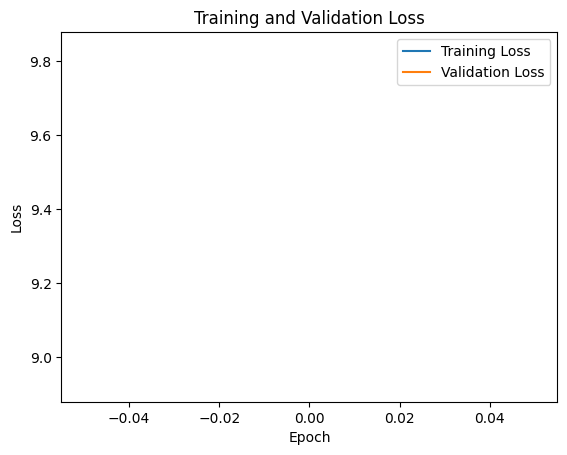

In [140]:
# Plotar histórico de loss
import matplotlib.pyplot as plt

if 'loss' in history.history and 'val_loss' in history.history:
    plt.plot( history.history[ 'loss' ], label = 'Training Loss' )
    plt.plot( history.history[ 'val_loss' ], label = 'Validation Loss' )
    plt.title( 'Training and Validation Loss' )
    plt.xlabel( 'Epoch' )
    plt.ylabel( 'Loss' )
    plt.legend()
    plt.show()
else:
    print( "Não foi possível plotar o gráfico de perdas. Verifique as chaves em 'history.history':",
           history.history.keys()
           )


In [141]:
# Retoma o treinamento
from tensorflow.keras.models import load_model

# Carrega o modelo salvo
if 0:
    bert_mlm_model = load_model( "bert_mlm.keras" )
    bert_mlm_model.fit( mlm_ds.repeat(), epochs = 5, steps_per_epoch = steps, callbacks = [ generator_callback ] )

# Predição de Frases

Utilização do modelo treinado para realizar a predição de novas frases.

In [142]:
import pandas as pd
import numpy as np


# Função para prever o token mascarado e mostrar top K predições
def predict_masked_token( text_with_mask: str, model, vectorize_layer, id2token, top_k = 5 ):
    """
    Prevê o token mascarado em uma frase e retorna as top K previsões com probabilidades.

    Args:
        text_with_mask (str): A frase de entrada contendo exatamente um token '[mask]'.
        model (keras.Model): O modelo treinado (MLM).
        vectorize_layer (TextVectorization): A camada de vetorização JÁ ADAPTADA.
        id2token (dict): Dicionário mapeando ID para token.
        top_k (int): Quantidade de melhores previsões a serem mostradas.

    Returns:
        pandas.DataFrame: DataFrame com as top K previsões, tokens e probabilidades.
                         Retorna None se '[mask]' não for encontrado ou mais de um for encontrado.
    """
    # 1. Vetorizar a frase de entrada
    #    O reshape [1, -1] adiciona a dimensão do batch (lote de tamanho 1)
    sample_tokens = vectorize_layer( [ text_with_mask ] )  # Não precisa de .numpy() aqui para predict

    # Verifica se a vetorização retornou algo e se tem o formato esperado
    if sample_tokens is None or sample_tokens.shape[ 0 ] == 0:
        print( "Erro: A vetorização não produziu uma saída válida." )
        return None

    # 2. Encontrar o índice do token [mask]
    #    `.numpy()` converte o tensor para numpy array para usar np.where
    #    Pega o id do token de máscara global que definimos antes
    masked_index_tuple = np.where( sample_tokens.cpu().numpy()[ 0 ] == mask_token_id )

    # Verifica se encontrou o token de máscara e se é apenas um
    if len( masked_index_tuple[ 0 ] ) != 1:
        print(
                f"Erro: Esperado exatamente um token '[mask]' na frase vetorizada, mas encontrado(s) {len( masked_index_tuple[ 0 ] )}."
        )
        print( f"Frase vetorizada: {sample_tokens.numpy()[ 0 ]}" )
        print( f"ID esperado para [mask]: {mask_token_id}" )
        # Tenta decodificar para ajudar a depurar
        try:
            decoded_tokens = [ id2token.get( int( t ), "[UNK]" ) for t in sample_tokens.numpy()[ 0 ] if t != 0 ]
            print( f"Tokens decodificados: {' '.join( decoded_tokens )}" )
        except Exception as e:
            print( f"Não foi possível decodificar os tokens: {e}" )
        return None

    masked_index = masked_index_tuple[ 0 ][ 0 ]  # Pega o índice escalar

    # 3. Fazer a predição com o modelo
    prediction = model.predict( sample_tokens )

    # 4. Extrair as probabilidades para a posição mascarada
    #    prediction[0] -> batch de tamanho 1
    #    prediction[0][masked_index] -> probabilidades para o token na posição mascarada
    mask_prediction_probabilities = prediction[ 0 ][ masked_index ]

    # 5. Encontrar os top K índices e suas probabilidades
    #    argsort() retorna os índices que ordenariam o array (do menor para o maior)
    #    [-top_k:] pega os K maiores índices
    #    [::-1] inverte para ter do maior para o menor
    top_indices = mask_prediction_probabilities.argsort()[ -top_k: ][ ::-1 ]
    top_probabilities = mask_prediction_probabilities[ top_indices ]

    # 6. Converter os IDs dos tokens previstos para palavras
    top_tokens = [ id2token.get( idx, "[UNK]" ) for idx in top_indices ]

    # 7. Criar e retornar um DataFrame com os resultados
    results_df = pd.DataFrame( {
        "Token Previsto": top_tokens,
        "Probabilidade": top_probabilities
    }
    )

    print( f"\nPredições para: '{text_with_mask}'" )
    return results_df

In [143]:
frase_teste_1 = "Pra sempre com [mask]"
resultados_df_1 = predict_masked_token( frase_teste_1, bert_masked_model, vectorize_layer, id2token, top_k = 10 )

if resultados_df_1 is not None:
    print( resultados_df_1.to_string( index = False ) )  # .to_string para melhor formatação no print

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Predições para: 'Pra sempre com [mask]'
Token Previsto  Probabilidade
           não       0.000368
             o       0.000360
            eu       0.000324
            me       0.000314
          você       0.000311
             é       0.000293
             a       0.000277
            um       0.000259
             e       0.000258
           pra       0.000250
